First steps:
- create model with 1 layer replaced by a transcoder
    - load in gpt-2
    - just pick a random layer, lets do layer 8 again
    - insert it.

In [2]:
# imports and setup
# all taken from transcoder paper
from transcoder_circuits.circuit_analysis import *
from transcoder_circuits.feature_dashboards import *
from transcoder_circuits.replacement_ctx import *

from sae_training.sparse_autoencoder import SparseAutoencoder
from transformer_lens import HookedTransformer, utils

model = HookedTransformer.from_pretrained('gpt2')


/data/gpfs/projects/punim2477/conda_envs/trans_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/gpfs/projects/punim2477/conda_envs/trans_env/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/data/gpfs/projects/punim2477/conda_envs/trans_env/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/data/gpfs/projects/punim2477/conda_envs/trans_env/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._

Loaded pretrained model gpt2 into HookedTransformer


In [3]:
# taken from transcoder paper
transcoder_template = "./gpt-2-small-transcoders/final_sparse_autoencoder_gpt2-small_blocks.{}.ln2.hook_normalized_24576"
transcoders = []
frequencies = []
for i in range(11):
    transcoders.append(SparseAutoencoder.load_from_pretrained(f"{transcoder_template.format(i)}.pt").eval())
    frequencies.append(torch.load(f"{transcoder_template.format(i)}_log_feature_sparsity.pt"))



In [4]:
# taken from attribution patching notebook https://colab.research.google.com/github/TransformerLensOrg/TransformerLens/blob/main/demos/Attribution_Patching_Demo.ipynb#scrollTo=fLb3GeMIbBZC
# slightly adapted

from transformer_lens import ActivationCache

# dont know what this does here
filter_not_qkv_input = lambda name: "_input" not in name



def get_cache_fwd_and_bwd(model, tokens, target_token):
    # need to add support for target logits being logits(target) - logits(not_target ie current_output) etc
    model.cfg.use_attn_result = True
    
    model.reset_hooks()
    cache = {}

    def forward_cache_hook(act, hook):
        cache[hook.name] = act.detach()

    model.add_hook(filter_not_qkv_input, forward_cache_hook, "fwd")

    grad_cache = {}

    def backward_cache_hook(act, hook):
        grad_cache[hook.name] = act.detach()

    model.add_hook(filter_not_qkv_input, backward_cache_hook, "bwd")
    # above is all code from the attribution patching notebook

    
    logits = model(tokens)
    #print("logits shape:", logits.shape) # for testing
    
    target_token_tokenized = model.to_tokens(target_token)
    #print("target token shape:", target_token_tokenized.shape) # for testing

    # Handle multi-token words
    tokenized = model.tokenizer.encode(target_token, add_special_tokens=False)
    assert len(tokenized) == 1, "Target token was split into multiple tokens!"
    target_token_id = tokenized[0]


    target_logits = logits[0,-1, target_token_id]
    # print(target_logits) # for testing
    
    model.zero_grad()
    target_logits.backward()
    model.reset_hooks()

    return (
        target_logits.item(),
        ActivationCache(cache, model),
        ActivationCache(grad_cache, model),
    )

In [ ]:
# try running the model with transcoders subbed in

# I'm not sure if all the shit I'm setting here is breaking the TranscoderReplacementContext() I'm running later, I'm not really sure what is happening
# bit embarrasing really.
# it might be easier to just start from scratch and remake the model so it's definitley got correct parts subbed in
model.cfg.use_attn_result = True
model.cfg.use_attn_in = True
model.cfg.use_split_qkv_input = True  # If using QKV hooks
model.cfg.use_hook_mlp_in = True
model.cfg.use_mlp_in = True

with TranscoderReplacementContext(model, transcoders[0:12]): # it appears that varrying the set of transcoders I sub in change the final logits, so I think it's doing something
                _, cache = model.run_with_cache("Example Test String!")
                tokens = model.to_tokens("Example Test String!")
                target_logits, fwd_cache, grad_cache = get_cache_fwd_and_bwd(model, tokens, "Test")

print("Tokens:", tokens)
print("Logits:", target_logits)
print("Activations cached:", len(fwd_cache))
print("Gradients cached:", len(grad_cache))

layer_idx = 8 # this is just for the example above
transcoder_hook_name = f"blocks.{layer_idx}.ln2.hook_normalized"

transcoder_feature_acts = fwd_cache[transcoder_hook_name]
transcoder_feature_grads = grad_cache[transcoder_hook_name]

# Print out the shape to verify
print(f"Transcoder feature gradients shape: {transcoder_feature_grads.shape}")
print(f"Transcoder feature activations shape: {transcoder_feature_acts.shape}")


# If you want to inspect individual feature gradients:
print("First 10 feature gradients:", transcoder_feature_grads[0, :10])
print("First 10 feature activations:", transcoder_feature_acts[0, :10])

print("Activations of a few features", transcoder_feature_acts[0, 0, 447]) # 447 the big one

# it's worth thinking about how these gradients and activations matter on earlier tokens too
# those contributions get dropped into the residual stream and can still be very relevant for the final output

# anyway I'm now getting an output, I'm not 100% sure if these gradients are meaningful, but its a start.



Tokens: tensor([[50256, 16281,  6208, 10903,     0]], device='cuda:0')
Logits: 7.424628734588623
Activations cached: 222
Gradients cached: 222
Transcoder feature gradients shape: torch.Size([1, 5, 768])
Transcoder feature activations shape: torch.Size([1, 5, 768])
First 10 feature gradients: tensor([[ 4.1337e-05, -9.6068e-05, -4.5741e-05,  ..., -3.4226e-05,
         -1.7645e-05, -9.9854e-05],
        [ 5.2577e-03, -4.6790e-03,  2.1589e-03,  ...,  3.8963e-03,
          2.8854e-04,  1.6894e-03],
        [-7.0971e-03,  9.8157e-04, -1.2323e-02,  ...,  8.6911e-04,
         -7.6186e-03, -5.0074e-03],
        [-2.1473e-03, -9.6283e-03, -3.7804e-03,  ..., -4.0381e-03,
          1.6279e-03,  7.6078e-03],
        [ 7.8838e-03, -3.7320e-02, -4.1202e-02,  ...,  4.0527e-02,
          9.7573e-03, -1.8355e-02]], device='cuda:0')
First 10 feature activations: tensor([[-0.0444, -0.0441, -0.0391,  ..., -0.0318, -0.0342, -0.0397],
        [-0.0244, -0.1799, -0.5312,  ..., -1.3339,  0.2573, -0.5839],
    

tensor([[7.0277e-05, 2.1020e-03, 6.0097e-03, 3.2923e-03, 2.0177e-02]],
       device='cuda:0')


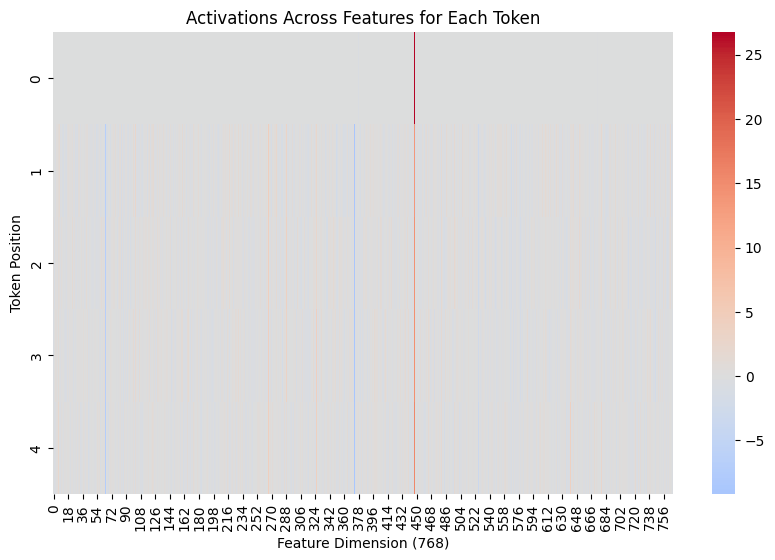

In [17]:
# lets do some visualization now:

feature_acts_norm = transcoder_feature_acts.abs().mean(dim=-1) # mean over the features dimensions
feature_grads_norm = transcoder_feature_grads.abs().mean(dim=-1)

print(feature_grads_norm)

# per feature gradient heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(transcoder_feature_acts.squeeze().cpu().numpy(), cmap="coolwarm", center=0)
plt.xlabel("Feature Dimension (768)")
plt.ylabel("Token Position")
plt.title("Activations Across Features for Each Token")
plt.show()

